### AUROC
- F1값은 정책과 임계값에 따라 달라짐
- 변화하는 임계값에 따른 모델의 성능 -> 모델의 강인함
- 두 클래스가 겹치는 구간이 적을 수록 모델 정확도에 유리함
- 그래프의 아래쪽 면적이 클수록 모델이 좋은 성능을 가짐

## 13.3 실습
### 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

In [10]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 데이터 분할

In [11]:
data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

torch.Size([569, 30]) torch.Size([569, 1])


In [12]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [13]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


### 데이터 정규화

In [14]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()]

### 하이퍼 파라미터 설정

In [15]:
n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100

### 모델 정의 및 최적화 설정
- 모델 구조의 마지막에 시그모이드 추가

In [16]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid(),
)

optimizer = optim.Adam(model.parameters())

In [17]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [19]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    train_loss = train_loss / len(x_)
    
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(
            'Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
                i + 1,
                train_loss,
                valid_loss,
                lowest_loss,
            )
        )

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=5.6917e-14  valid_loss=3.0505e+00  lowest_loss=3.0505e+00
Epoch 20: train loss=5.6706e-14  valid_loss=3.0505e+00  lowest_loss=3.0505e+00
Epoch 30: train loss=5.6779e-14  valid_loss=3.0505e+00  lowest_loss=3.0505e+00
Epoch 40: train loss=5.6494e-14  valid_loss=3.0506e+00  lowest_loss=3.0505e+00
Epoch 50: train loss=5.6353e-14  valid_loss=3.0506e+00  lowest_loss=3.0505e+00
Epoch 60: train loss=5.6358e-14  valid_loss=3.0506e+00  lowest_loss=3.0505e+00
Epoch 70: train loss=5.6126e-14  valid_loss=3.0506e+00  lowest_loss=3.0505e+00
Epoch 80: train loss=5.6143e-14  valid_loss=3.0506e+00  lowest_loss=3.0505e+00
Epoch 90: train loss=5.5900e-14  valid_loss=3.0506e+00  lowest_loss=3.0505e+00
Epoch 100: train loss=5.5819e-14  valid_loss=3.0506e+00  lowest_loss=3.0505e+00
There is no improvement during last 100 epochs.
The best validation loss from epoch 1: 3.0505e+00


<All keys matched successfully>

In [20]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

data = torch.from_numpy(df.values).float()

x = data[:, :-1]
y = data[:, -1:]

print(x.shape, y.shape)

# Train / Valid / Test ratio
ratios = [.6, .2, .2]

train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

scaler = StandardScaler()
scaler.fit(x[0].numpy())

x = [torch.from_numpy(scaler.transform(x[0].numpy())).float(),
     torch.from_numpy(scaler.transform(x[1].numpy())).float(),
     torch.from_numpy(scaler.transform(x[2].numpy())).float()]

n_epochs = 10000
batch_size = 32
print_interval = 10
early_stop = 100

model = nn.Sequential(
    nn.Linear(x[0].size(-1), 25),
    nn.LeakyReLU(),
    nn.Linear(25, 20),
    nn.LeakyReLU(),
    nn.Linear(20, 15),
    nn.LeakyReLU(),
    nn.Linear(15, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].size(-1)),
    nn.Sigmoid(),
)

optimizer = optim.Adam(model.parameters())

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    train_loss = train_loss / len(x_)
    
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(
            'Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
                i + 1,
                train_loss,
                valid_loss,
                lowest_loss,
            )
        )

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

torch.Size([569, 30]) torch.Size([569, 1])
Train 341 / Valid 113 / Test 115 samples.
torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])
Epoch 10: train loss=2.8269e-01  valid_loss=2.4157e-01  lowest_loss=2.5692e-01
Epoch 20: train loss=3.3292e-02  valid_loss=8.2100e-02  lowest_loss=6.4123e-02
Epoch 30: train loss=2.2209e-02  valid_loss=1.1980e-01  lowest_loss=6.4123e-02
Epoch 40: train loss=1.3351e-02  valid_loss=1.1555e-01  lowest_loss=6.4123e-02
Epoch 50: train loss=5.2880e-03  valid_loss=1.6480e-01  lowest_loss=6.4123e-02
Epoch 60: train loss=1.3776e-03  valid_loss=1.6777e-01  lowest_loss=6.4123e-02
Epoch 70: train loss=6.4528e-04  valid_loss=1.8501e-01  lowest_loss=6.4123e-02
Epoch 80: train loss=3.7224e-04  valid_loss=1.8402e-01  lowest_loss=6.4123e-02
Epoch 90: train loss=2.2897e-04  valid_loss=1.8845e-01  lowest_loss=6.4123e-02
Epoch 100: train loss=1.6110e-04  valid_loss=1.8466e-01  lowest_loss=6.4123

<All keys matched successfully>

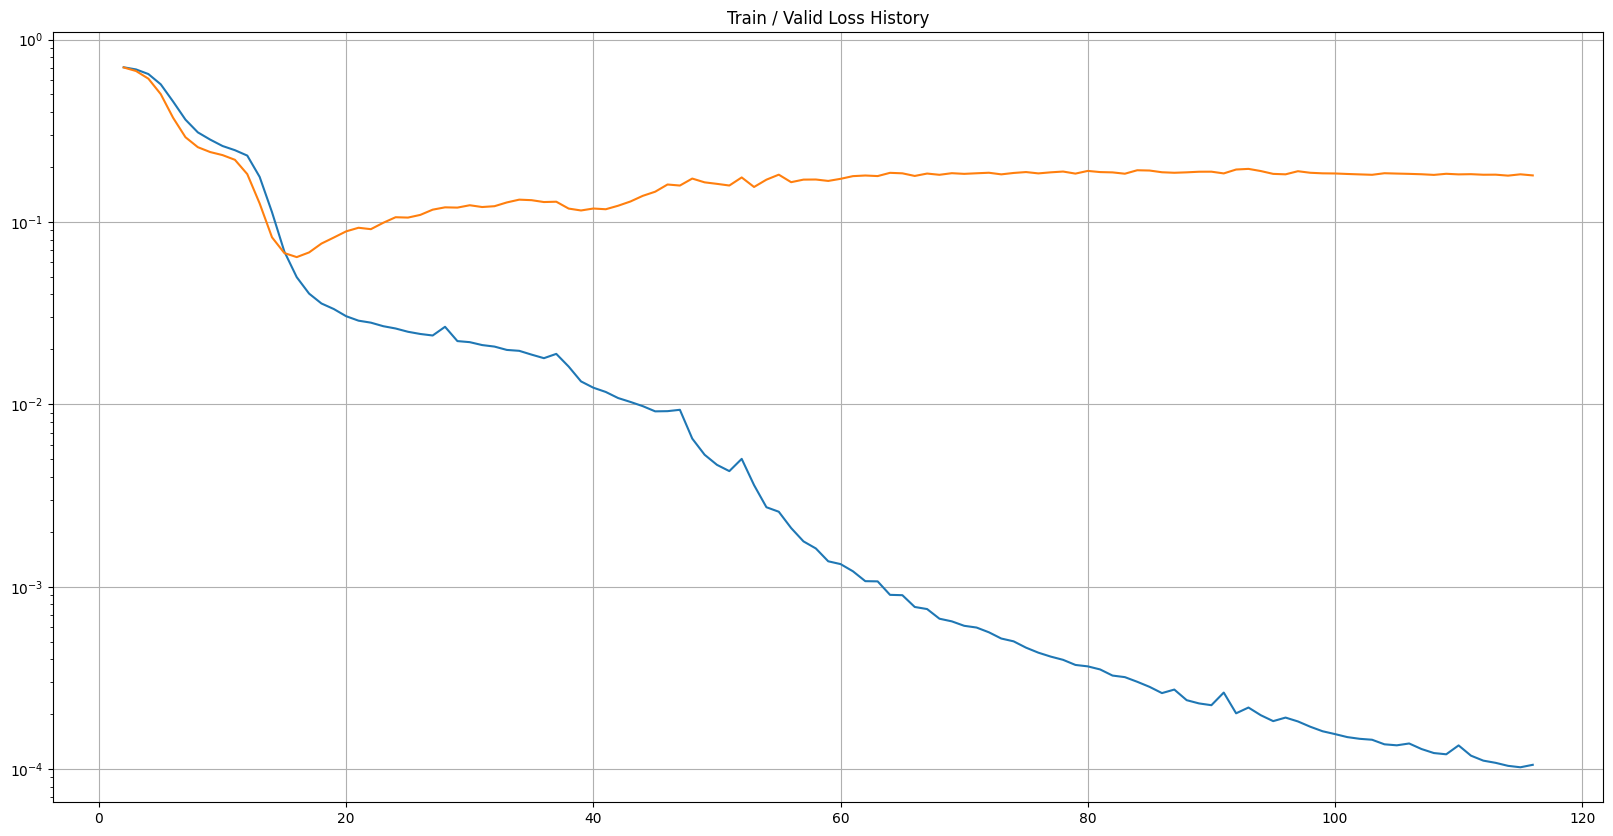

In [21]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

- 오버피팅 발생 (검증 데이터 부분 상승)
- 데이터의 크기보다 모델의 복잡도가 높기 때문

## 13.5 소프트맥스 함수와 교차 엔트로피 손실 함수
### 소프트맥스 함수
- max 함수의 소프트 버전
- 임의의 벡터를 입력받아 이산 확률 분포의 형태로 출력
- 정답이 되는 것은 1에 가깝게 되고 정답이 아닌 것은 0에 가깝게 됨
- 확률 분포이므로 총합은 1
- 비교 하드맥스의 경우라면, 가장 큰 값만 1이 되고 나머지는 0이 됨

## 13.6 다중 클래스 분류 결과 분석하기
### 혼동 행렬

## 13.7 실습
### 데이터 준비

In [23]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

100.0%
100.0%
100.0%
100.0%


/var/folders/4n/bn2y9j953s9cm6hn2_vxqphm0000gn/T/ipykernel_5657/1231001756.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)


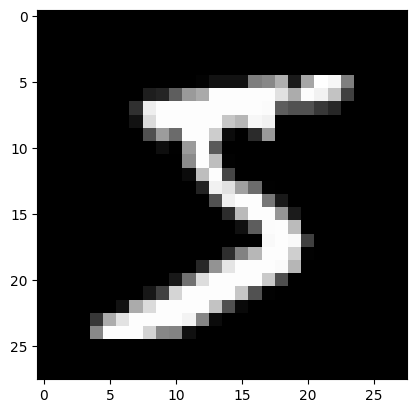

In [24]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)

    plt.imshow(img, cmap='gray')
    plt.show()

plot(train.data[0])

### 데이터 형태 변경

In [25]:
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


### 데이터 분할

In [27]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [ ]:
### 하이퍼파라미터 설정

In [55]:
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [56]:
### 모델 정의

In [57]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

model 

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

### 손실함수와 최적화 설정

In [58]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

### GPU 사용을 위한 코드

In [59]:
device = torch.device("cpu")

if torch.cuda.is_available():   # NVIDIA GPU 
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # cuda 없으면 Apple Silicon GPU로 설정하는 코드
    device = torch.device("mps")

print("Using device:", device)

Using device: mps


In [60]:
model = model.to(device) # model을 그래픽카드에 있는 메모리로 이동

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

### 학습

In [61]:
import time
start = time.time()

train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)
            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print('Epoch %d/%d: train_loss=%.4f valid_loss=%.4f lowest_loss=%.4f elapsed_time=%.2fsec'%(
              (i+1), n_epochs, 
              train_loss,
              valid_loss,
              lowest_loss,
              time.time() - start
             ))
        start = time.time()

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" %
      (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10/1000: train_loss=0.0229 valid_loss=0.1165 lowest_loss=0.0956 elapsed_time=17.03sec
Epoch 20/1000: train_loss=0.0098 valid_loss=0.1121 lowest_loss=0.0956 elapsed_time=16.78sec
Epoch 30/1000: train_loss=0.0068 valid_loss=0.1263 lowest_loss=0.0956 elapsed_time=17.25sec
Epoch 40/1000: train_loss=0.0025 valid_loss=0.1237 lowest_loss=0.0956 elapsed_time=16.75sec
Epoch 50/1000: train_loss=0.0087 valid_loss=0.1211 lowest_loss=0.0956 elapsed_time=17.09sec
There is no improvement during last 50 epochs.
The best validation loss from epoch 8: 9.5604e-02


<All keys matched successfully>

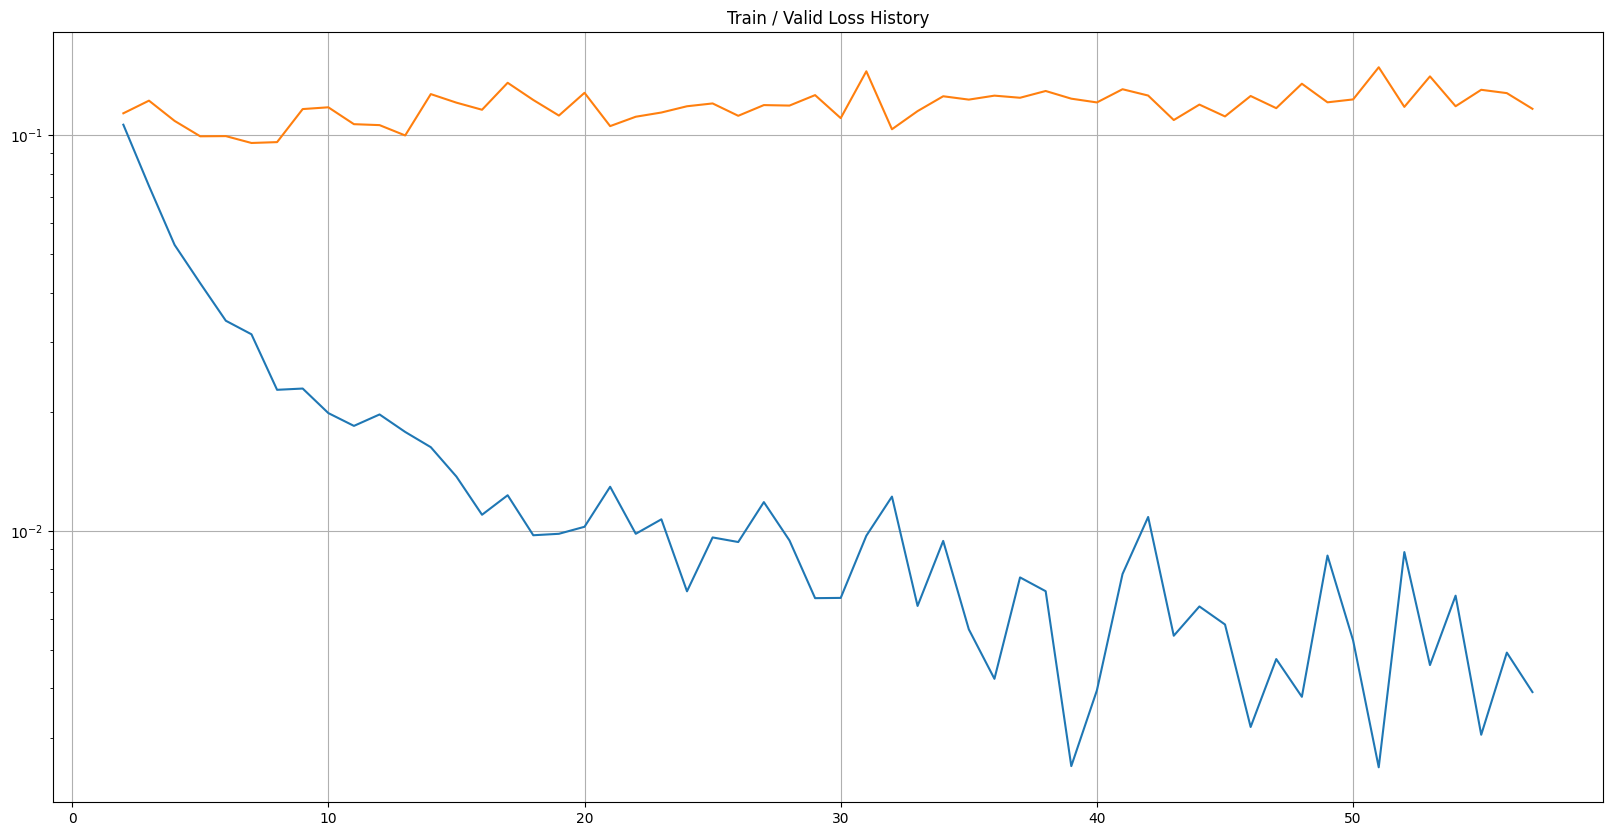

In [62]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

### 레포트
- 알고있는 하이퍼파라미터를 가지고 여러가지를 변경해가면서 시각적으로 개선되는 것을 보여주기
- 우리가 알고있는 하이퍼파라미터: model, n_epochs, early_stop, batch_size

결론: 무엇을 변경하였더니 1 몇 에폭에서 종료되었고, 2 best가 어디고 3 그때의 손실이 얼마였는지, 4 각 수정마다 Train/Valid Loss History 첨부

## 14.1 정규화
### 오버피팅
- 학습 오류가 일반화 오차에 비해서 현격하게 낮아지는 현상
- 학습 데이터의 편향이나 노이즈까지 학습

### 정규화 혼동 표기
- nomalization
- ...
- regularization: 오버피팅이 발생하지 않도록 가중치 조정(손실함수)을 규제

### 정규화(Regularization)란?
- 오버피팅을 늦추고 모델이 학습 데이터로부터 적절한 특징들을 학습하여 일반화 오타를 낮춰줄 수 있는 기법

